# Fraud Detection Case Study
This notebook analyzes a financial transactions dataset to detect fraudulent behavior. We will go through dataset exploration, preprocessing, model building, and evaluation.

## Loading Dataset

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [13]:
df = pd.read_csv('Fraud.csv')

In [14]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [16]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

## Explorator Data Analysis

In [17]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

## Dataset Overview
**Features provided:**
- **step**: Unit of time in hours (1 step = 1 hour). Simulation runs for 744 steps (30 days).
- **type**: Transaction type (CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER).
- **amount**: Transaction amount in local currency.
- **nameOrig**: Customer initiating the transaction.
- **oldbalanceOrg**: Initial balance before the transaction.
- **newbalanceOrig**: Balance after the transaction.
- **nameDest**: Recipient of the transaction.
- **oldbalanceDest**: Initial balance of recipient before transaction (NaN for merchants `M`).
- **newbalanceDest**: Balance of recipient after transaction (NaN for merchants `M`).
- **isFraud**: Indicates if transaction is fraudulent.
- **isFlaggedFraud**: Flags illegal attempts (transfers > 200,000).

In [18]:
df["isFlaggedFraud"].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [19]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [20]:
fraud_percentage = round((df["isFraud"].value_counts()[1] / df.shape[0] )* 100, 3)
fraud_percentage

0.129

Text(0, 0.5, 'Count')

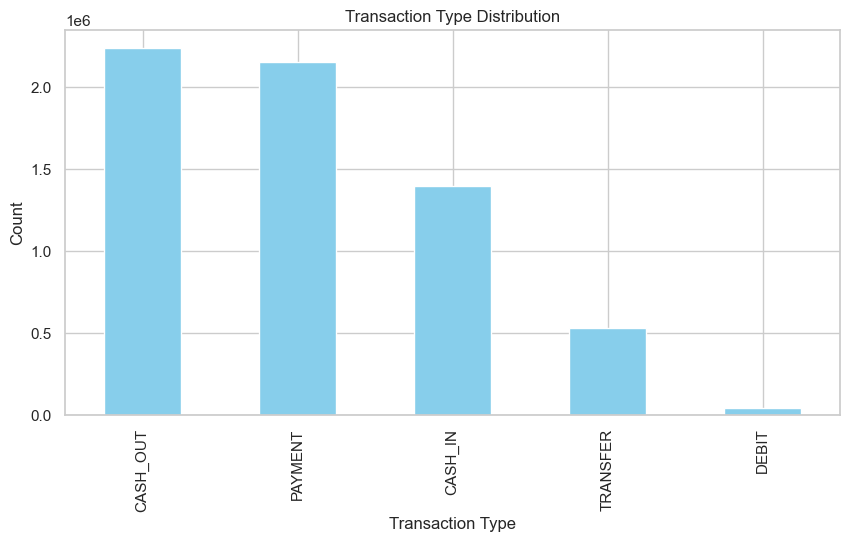

In [21]:
df["type"].value_counts().plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title('Transaction Type Distribution')
plt.xlabel('Transaction Type')
plt.ylabel('Count')

Text(0, 0.5, 'Fraud Rate')

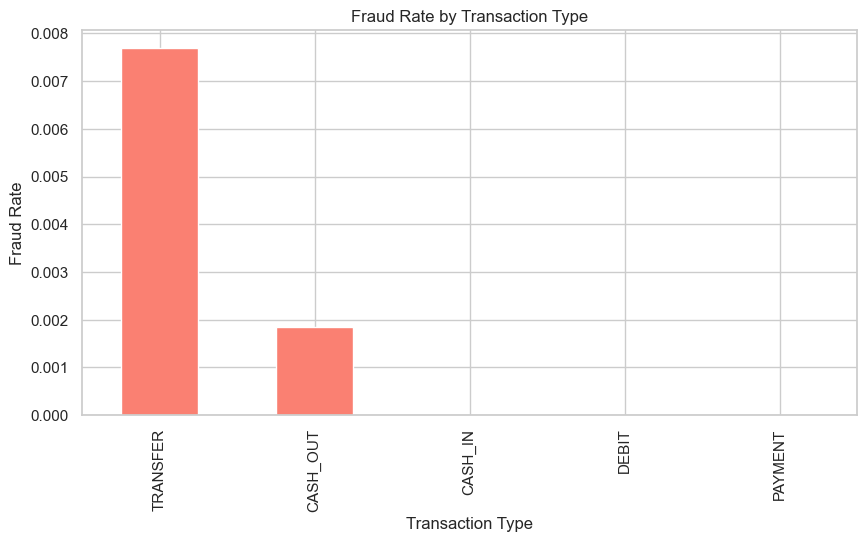

In [22]:
fraud_by_type=df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
fraud_by_type.plot(kind='bar', figsize=(10, 5), color='salmon')
plt.title('Fraud Rate by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Rate')

In [23]:
df["amount"].describe().astype(int)

count     6362620
mean       179861
std        603858
min             0
25%         13389
50%         74871
75%        208721
max      92445516
Name: amount, dtype: int32

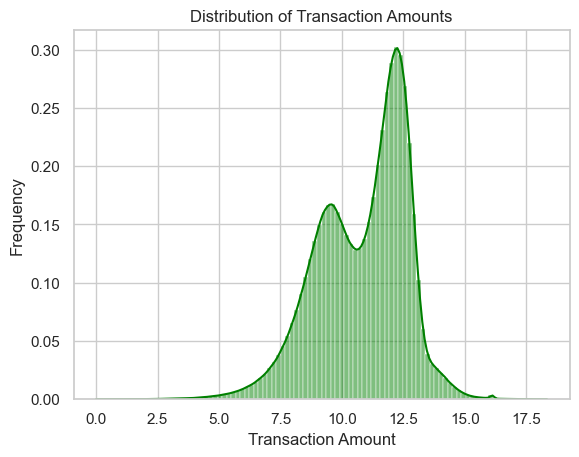

In [24]:
sns.histplot(np.log1p(df["amount"]), bins=100,kde=True, color='green', stat='density')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Boxplot of Transaction Amounts by Fraud Status')

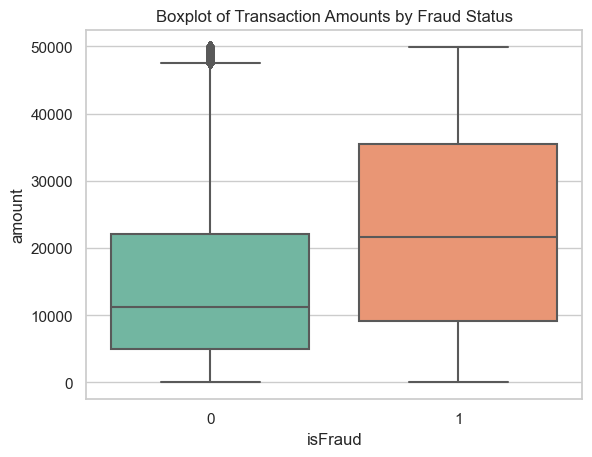

In [25]:
sns.boxplot(data=df[df["amount"]<50000] , x='isFraud', y='amount', palette='Set2')
plt.title('Boxplot of Transaction Amounts by Fraud Status')

In [26]:
df['balancedDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balancedDiffDest'] = -df['oldbalanceDest'] + df['newbalanceDest']

## Key Business Questions
1. What percentage of transactions are fraudulent?
2. Which transaction types are more likely to be fraudulent?
3. How effective is the business rule (`isFlaggedFraud`) in catching frauds?
4. Can we build a machine learning model to improve fraud detection?

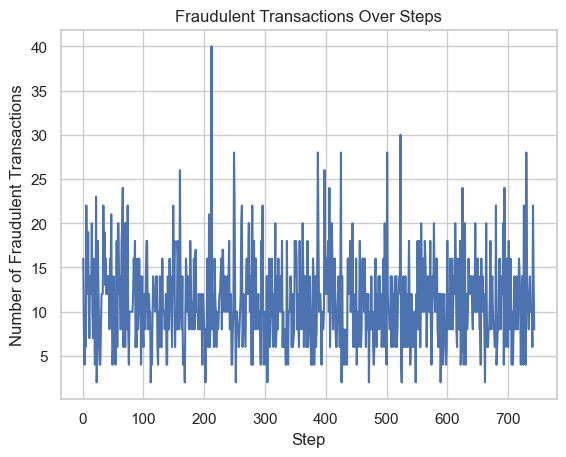

In [27]:
fraud_per_step= df[df["isFraud"]==1]["step"].value_counts().sort_index()
plt.plot(fraud_per_step.index, fraud_per_step.values, label="Fraud Per Step")
plt.title('Fraudulent Transactions Over Steps')
plt.xlabel('Step')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

In [28]:
df.drop(columns="step", inplace=True)

In [29]:
top_senders = df["nameOrig"].value_counts().head(10)
top_senders

nameOrig
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
C1677795071    3
C1462946854    3
C1999539787    3
C2098525306    3
C400299098     3
Name: count, dtype: int64

In [30]:
top_receivers = df["nameDest"].value_counts().head(10)
top_receivers

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
Name: count, dtype: int64

In [31]:
fraud_users = df[df["isFraud"] == 1]["nameOrig"].value_counts().head(10)
fraud_users

nameOrig
C1305486145    1
C755286039     1
C973279667     1
C258213312     1
C1640703547    1
C1127265876    1
C317779855     1
C1064034527    1
C1141104763    1
C1966863341    1
Name: count, dtype: int64

In [32]:
fraud_types = df[df["isFraud"] == 1]["type"].value_counts()
fraud_types

type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64

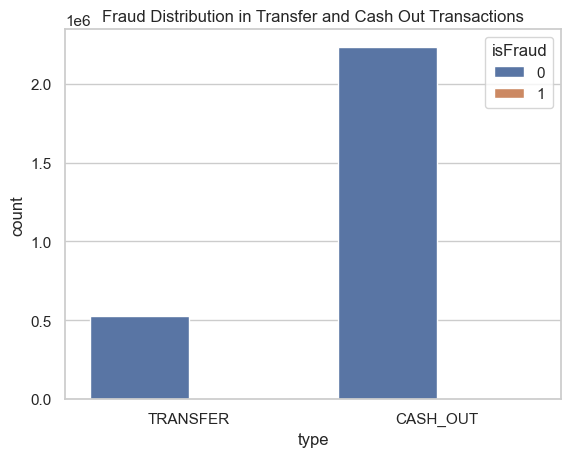

In [33]:
# Filter relevant types
fraud_types = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]

# Ensure 'isFraud' is clean
fraud_types['isFraud'] = fraud_types['isFraud'].astype(int)

# Plot
sns.countplot(data=fraud_types, x="type", hue="isFraud")
plt.title('Fraud Distribution in Transfer and Cash Out Transactions')
plt.show()


In [34]:
corr = df[["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest","isFraud"]].corr()

## Exploratory Data Analysis (EDA)
- Distribution of transaction types
- Fraud vs non-fraud transaction comparison
- Balance changes in fraud transactions
- High-value transactions and flagged fraud analysis

In [35]:
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

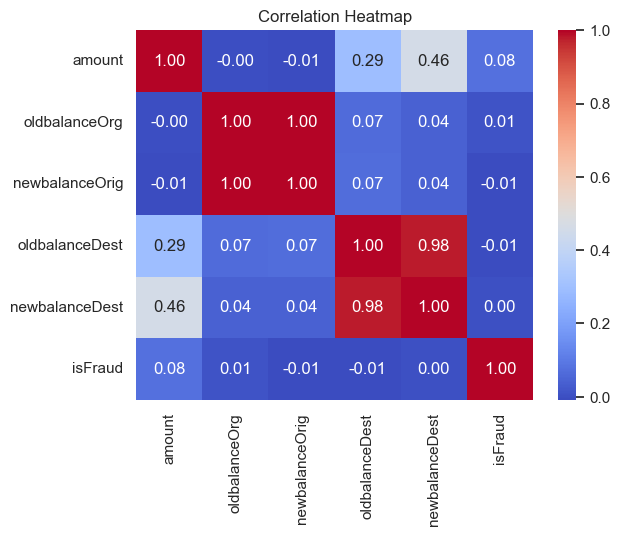

In [36]:
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')

In [37]:
zero_after_transfer = df[
    (df["oldbalanceOrg"] > 0)
    & (df["newbalanceOrig"] == 0)
    & (df["type"].isin(["TRANSFER","CASH_OUT"]))
]
len(zero_after_transfer)

1188074

In [38]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

## Feature Selection


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [40]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balancedDiffOrig,balancedDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [41]:
df_model= df.drop(columns=["nameOrig", "nameDest", "isFlaggedFraud"],axis=1)

In [42]:
df_model.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balancedDiffOrig,balancedDiffDest
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,9839.64,0.0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,1864.28,0.0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,181.00,0.0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,181.00,-21182.0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,11668.14,0.0


## Model Building
- Feature engineering (handling categorical variables, balances, amounts)
- Handling class imbalance
- Training ML models (Logistic Regression, Random Forest, XGBoost)
- Evaluation metrics (Accuracy, Precision, Recall, F1, ROC-AUC)

> ⚠️ In fraud detection, **Recall and Precision** are more important than Accuracy, since fraud cases are rare and costly.

In [43]:
categorical = ["type"]
numerical = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]

In [44]:
y= df_model["isFraud"]
X = df_model.drop(columns=["isFraud"], axis=1)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [46]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical),
        ("cat", OneHotEncoder(), categorical)
    ],
    remainder='drop'
)

In [47]:
pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

In [48]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat', OneHotEncoder(),
                                                  ['type'])])),
                ('clf', LogisticRegression(max_iter=1000))])

In [49]:
y_pred = pipeline.predict(X_test)

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.92      0.36      0.52      2464

    accuracy                           1.00   1908786
   macro avg       0.96      0.68      0.76   1908786
weighted avg       1.00      1.00      1.00   1908786



In [51]:
confusion_matrix(y_test, y_pred)

array([[1906244,      78],
       [   1575,     889]], dtype=int64)

## Results & Insights
- Fraudulent transactions are mostly concentrated in **CASH-OUT** and **TRANSFER** types.
- The business rule (`isFlaggedFraud`) captures only a tiny fraction of actual frauds.
- ML models significantly improve fraud detection, but careful threshold tuning is required to balance false positives and false negatives.

👉 Next steps: Deploy model into a monitoring pipeline and periodically retrain with new data.

In [54]:
pipeline.score(X_test, y_test) * 100

99.91340045452974

In [55]:
import joblib
joblib.dump(pipeline, 'fraud_detection_model.pkl')

['fraud_detection_model.pkl']